# Introduction

# Particle identification: Training a classifier to detect electrons, protons, muons, kaons and pions in the Large Hadron Collider.

In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# For example, here's several helpful packages to load in 

import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import xgboost as xg
import tables as tb
from tqdm import tqdm
from IPython import display
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import Normalizer
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import log_loss
from keras.layers.core import Dense, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
import utils

%matplotlib inline
%pylab inline



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/"))

# Any results you write to the current directory are saved as output.

Populating the interactive namespace from numpy and matplotlib
['particle-identification', 'dark-matter-from-opera-experiments']


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf', 'display', 'figsize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Particle Identification

load the datasets

In [58]:
training = pd.read_csv('../input/particle-identification/training.csv')
test = pd.read_csv('../input/particle-identification/test.csv')

In [59]:
training.head()

,TrackP,TrackNDoFSubdetector2,BremDLLbeElectron,MuonLooseFlag,FlagSpd,SpdE,EcalDLLbeElectron,DLLmuon,RICHpFlagElectron,EcalDLLbeMuon,TrackQualitySubdetector2,FlagPrs,DLLelectron,DLLkaon,EcalE,TrackQualityPerNDoF,DLLproton,PrsDLLbeElectron,FlagRICH1,MuonLLbeBCK,FlagHcal,EcalShowerLongitudinalParameter,Calo2dFitQuality,TrackPt,TrackDistanceToZ,RICHpFlagPion,HcalDLLbeElectron,Calo3dFitQuality,FlagEcal,MuonLLbeMuon,TrackNDoFSubdetector1,RICHpFlagProton,RICHpFlagKaon,GhostProbability,TrackQualitySubdetector1,Label,RICH_DLLbeBCK,FlagRICH2,FlagBrem,HcalDLLbeMuon,TrackNDoF,RICHpFlagMuon,RICH_DLLbeKaon,RICH_DLLbeElectron,HcalE,MuonFlag,FlagMuon,PrsE,RICH_DLLbeMuon,RICH_DLLbeProton
0,74791.156263,15.0,0.232275,1.0,1.0,3.2,-2.505719,6.604153,1.0,1.929960,17.585680,1.0,-6.411697,-7.213295,0.000001,1.467550,-26.667494,-2.730674,1.0,-5.152923,1.0,-999.000000,19.954819,3141.930677,0.613640,1.0,-0.909544,-999.000000,1.0,-0.661823,4.0,1.0,1.0,0.018913,5.366212,Muon,-21.913000,1.0,1.0,1.015345,28.0,1.0,-7.213300,-0.280200,5586.589846,1.0,1.0,10.422315,-2.081143e-07,-24.824400
1,2738.489989,15.0,-0.357748,0.0,1.0,3.2,1.864351,0.263651,1.0,-2.061959,20.230680,1.0,5.453014,0.000006,1531.542000,3.570540,-0.711194,1.773806,1.0,-999.000000,0.0,33.187644,0.037601,199.573653,0.465480,1.0,0.434909,13.667366,1.0,-999.000000,10.0,0.0,0.0,0.351206,9.144749,Ghost,-0.703617,0.0,1.0,-2.394644,32.0,1.0,-0.324317,1.707283,-0.000007,0.0,1.0,43.334935,2.771583e+00,-0.648017
2,2161.409908,17.0,-999.000000,0.0,0.0,-999.0,-999.000000,-999.000000,0.0,-999.000000,11.619878,0.0,-999.000000,-999.000000,-999.000000,0.826442,-999.000000,-999.000000,0.0,-999.000000,0.0,-999.000000,-999.000000,94.829418,0.241891,0.0,-999.000000,-999.000000,0.0,-999.000000,5.0,0.0,0.0,0.195717,1.459992,Ghost,-999.000000,0.0,0.0,-999.000000,27.0,0.0,-999.000000,-999.000000,-999.000000,0.0,0.0,-999.000000,-9.990000e+02,-999.000000
3,15277.730490,20.0,-0.638984,0.0,1.0,3.2,-2.533918,-8.724949,1.0,-3.253981,15.336305,1.0,-10.616585,-39.447507,4385.688000,1.076721,-29.291509,-3.053104,1.0,-999.000000,1.0,231.190351,2.839508,808.631064,0.680705,1.0,-1.504160,1939.259641,1.0,-999.000000,9.0,0.0,1.0,0.003972,22.950573,Pion,-47.223118,1.0,1.0,-0.321242,36.0,1.0,-35.202221,-14.742319,4482.803707,0.0,1.0,2.194175,-3.070819e+00,-29.291519
4,7563.700195,19.0,-0.638962,0.0,1.0,3.2,-2.087146,-7.060422,1.0,-0.995816,10.954629,1.0,-8.144945,26.050386,1220.930044,0.439767,21.386587,-2.730648,1.0,-999.000000,1.0,-794.866475,1.209193,1422.569214,0.575066,1.0,-1.576249,1867.165142,1.0,-999.000000,5.0,0.0,0.0,0.015232,3.516173,Proton,15.304688,0.0,1.0,-1.038026,33.0,1.0,25.084287,-10.272412,5107.554680,0.0,1.0,0.000015,-5.373712e+00,23.653087


In [60]:
test.head()

,TrackP,TrackNDoFSubdetector2,BremDLLbeElectron,MuonLooseFlag,FlagSpd,SpdE,EcalDLLbeElectron,DLLmuon,RICHpFlagElectron,EcalDLLbeMuon,TrackQualitySubdetector2,FlagPrs,DLLelectron,DLLkaon,EcalE,TrackQualityPerNDoF,DLLproton,PrsDLLbeElectron,FlagRICH1,MuonLLbeBCK,FlagHcal,EcalShowerLongitudinalParameter,Calo2dFitQuality,TrackPt,TrackDistanceToZ,RICHpFlagPion,HcalDLLbeElectron,Calo3dFitQuality,FlagEcal,MuonLLbeMuon,TrackNDoFSubdetector1,RICHpFlagProton,RICHpFlagKaon,GhostProbability,TrackQualitySubdetector1,RICH_DLLbeBCK,FlagRICH2,FlagBrem,HcalDLLbeMuon,TrackNDoF,RICHpFlagMuon,RICH_DLLbeKaon,RICH_DLLbeElectron,HcalE,MuonFlag,FlagMuon,PrsE,RICH_DLLbeMuon,RICH_DLLbeProton,ID
0,55086.199233,18.0,-0.438763,0.0,1.0,3.2,-1.843821,-4.579244,1.0,-1.732886,22.757613,1.0,-6.392882,16.911903,4416.383799,1.176239,37.200702,-2.321282,1.0,-999.000000,1.0,170.771073,0.328454,1732.758804,0.678807,1.0,-1.409228,3431.213151,1.0,-999.000000,7.0,0.0,1.0,0.004411,6.541830,22.749886,1.0,1.0,-1.790535,34.0,1.0,18.674086,-1.355015,24510.990244,0.0,1.0,9.325265,-0.250015,35.408585,0
1,3393.820071,17.0,-0.554341,0.0,1.0,0.0,-0.883237,-6.203035,1.0,-0.097206,21.951430,1.0,-6.867096,15.577288,0.000007,3.497992,11.866988,-2.460519,1.0,-999.000000,1.0,542.144654,20.769733,261.281253,0.170659,1.0,-0.600473,726.542115,1.0,-999.000000,8.0,0.0,0.0,0.046897,8.506494,11.725304,0.0,1.0,-0.289500,34.0,1.0,16.536804,-17.601196,778.675303,0.0,1.0,-0.000006,-6.646096,14.011904,1
2,18341.359361,12.0,-0.554339,0.0,1.0,0.0,-2.653786,-3.922639,1.0,0.936484,7.882976,1.0,-8.499948,0.000006,-0.000002,0.752767,-4.892094,-2.805346,1.0,-999.000000,1.0,6090.963363,37.769978,681.985887,0.485022,1.0,-1.926941,4777.214828,1.0,-999.000000,7.0,1.0,1.0,0.002792,9.069770,-1.835909,1.0,1.0,-1.441898,30.0,1.0,-1.306109,-4.536409,7915.212420,0.0,1.0,1.371346,-2.132609,-5.617409,2
3,27486.710933,7.0,-0.492411,1.0,1.0,3.2,-999.000000,2.034453,1.0,-999.000000,13.373016,1.0,0.322580,-2.280805,-999.000000,1.438089,-8.657205,-0.075777,1.0,-0.476107,0.0,-999.000000,-999.000000,1267.466426,0.277881,1.0,-999.000000,-999.000000,0.0,-0.018407,6.0,1.0,1.0,0.003242,8.600039,1.848607,1.0,1.0,-999.000000,21.0,1.0,-4.222793,3.149207,-999.000000,1.0,1.0,61.985428,0.946207,-8.657193,3
4,6842.249996,16.0,0.098706,0.0,1.0,3.2,2.644499,-1.471364,1.0,-2.909470,18.442923,1.0,1.970983,-3.425082,2965.656006,0.866863,-5.322182,-3.011893,1.0,-999.000000,1.0,657.940203,1.674208,232.944958,2.554630,1.0,0.596886,17.644837,1.0,-999.000000,4.0,0.0,0.0,0.006850,2.285350,-6.326513,0.0,1.0,-2.463674,29.0,1.0,-3.425113,23.147387,-0.000013,0.0,1.0,2.468453,2.614987,-5.713513,4


In [61]:
print(test.shape)
print(training.shape)

(1200000, 50)


(1200000, 50)

In [62]:
training['Label'].value_counts()

Kaon        200000
Pion        200000
Proton      200000
Ghost       200000
Muon        200000
Electron    200000
Name: Label, dtype: int64

In [63]:
training.columns

Index(['TrackP', 'TrackNDoFSubdetector2', 'BremDLLbeElectron', 'MuonLooseFlag',
       'FlagSpd', 'SpdE', 'EcalDLLbeElectron', 'DLLmuon', 'RICHpFlagElectron',
       'EcalDLLbeMuon', 'TrackQualitySubdetector2', 'FlagPrs', 'DLLelectron',
       'DLLkaon', 'EcalE', 'TrackQualityPerNDoF', 'DLLproton',
       'PrsDLLbeElectron', 'FlagRICH1', 'MuonLLbeBCK', 'FlagHcal',
       'EcalShowerLongitudinalParameter', 'Calo2dFitQuality', 'TrackPt',
       'TrackDistanceToZ', 'RICHpFlagPion', 'HcalDLLbeElectron',
       'Calo3dFitQuality', 'FlagEcal', 'MuonLLbeMuon', 'TrackNDoFSubdetector1',
       'RICHpFlagProton', 'RICHpFlagKaon', 'GhostProbability',
       'TrackQualitySubdetector1', 'Label', 'RICH_DLLbeBCK', 'FlagRICH2',
       'FlagBrem', 'HcalDLLbeMuon', 'TrackNDoF', 'RICHpFlagMuon',
       'RICH_DLLbeKaon', 'RICH_DLLbeElectron', 'HcalE', 'MuonFlag', 'FlagMuon',
       'PrsE', 'RICH_DLLbeMuon', 'RICH_DLLbeProton'],
      dtype='object')

In [64]:
test.columns

Index(['TrackP', 'TrackNDoFSubdetector2', 'BremDLLbeElectron', 'MuonLooseFlag',
       'FlagSpd', 'SpdE', 'EcalDLLbeElectron', 'DLLmuon', 'RICHpFlagElectron',
       'EcalDLLbeMuon', 'TrackQualitySubdetector2', 'FlagPrs', 'DLLelectron',
       'DLLkaon', 'EcalE', 'TrackQualityPerNDoF', 'DLLproton',
       'PrsDLLbeElectron', 'FlagRICH1', 'MuonLLbeBCK', 'FlagHcal',
       'EcalShowerLongitudinalParameter', 'Calo2dFitQuality', 'TrackPt',
       'TrackDistanceToZ', 'RICHpFlagPion', 'HcalDLLbeElectron',
       'Calo3dFitQuality', 'FlagEcal', 'MuonLLbeMuon', 'TrackNDoFSubdetector1',
       'RICHpFlagProton', 'RICHpFlagKaon', 'GhostProbability',
       'TrackQualitySubdetector1', 'RICH_DLLbeBCK', 'FlagRICH2', 'FlagBrem',
       'HcalDLLbeMuon', 'TrackNDoF', 'RICHpFlagMuon', 'RICH_DLLbeKaon',
       'RICH_DLLbeElectron', 'HcalE', 'MuonFlag', 'FlagMuon', 'PrsE',
       'RICH_DLLbeMuon', 'RICH_DLLbeProton', 'ID'],
      dtype='object')

From the dataset description, we know that the features describe particle responses in the detector systems, and represent the following:

- ID - id value for tracks (presents only in the test file for the submitting purposes)
- Label - string valued observable denoting particle types. Can take values "Electron", "Muon", "Kaon", "Proton", "Pion" and "Ghost". This column is absent in the test file.
- FlagSpd - flag (0 or 1), if reconstructed track passes through Spd
- FlagPrs - flag (0 or 1), if reconstructed track passes through Prs
- FlagBrem - flag (0 or 1), if reconstructed track passes through Brem
- FlagEcal - flag (0 or 1), if reconstructed track passes through Ecal
- FlagHcal - flag (0 or 1), if reconstructed track passes through Hcal
- FlagRICH1 - flag (0 or 1), if reconstructed track passes through the first RICH detector
- FlagRICH2 - flag (0 or 1), if reconstructed track passes through the second RICH detector
- FlagMuon - flag (0 or 1), if reconstructed track passes through muon stations (Muon)
- SpdE - energy deposit associated to the track in the Spd
- PrsE - energy deposit associated to the track in the Prs
- EcalE - energy deposit associated to the track in the Hcal
- HcalE - energy deposit associated to the track in the Hcal
- PrsDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Prs
- BremDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Brem
- TrackP - particle momentum
- TrackPt - particle transverse momentum
- TrackNDoFSubdetector1  - number of degrees of freedom for track fit using hits in the tracking sub-detector1
- TrackQualitySubdetector1 - chi2 quality of the track fit using hits in the tracking sub-detector1
- TrackNDoFSubdetector2 - number of degrees of freedom for track fit using hits in the tracking sub-detector2
- TrackQualitySubdetector2 - chi2 quality of the track fit using hits in the  tracking sub-detector2
- TrackNDoF - number of degrees of freedom for track fit using hits in all tracking sub-detectors
- TrackQualityPerNDoF - chi2 quality of the track fit per degree of freedom
- TrackDistanceToZ - distance between track and z-axis (beam axis)
- Calo2dFitQuality - quality of the 2d fit of the clusters in the calorimeter 
- Calo3dFitQuality - quality of the 3d fit in the calorimeter with assumption that particle was electron
- EcalDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Ecal
- EcalDLLbeMuon - delta log-likelihood for a particle candidate to be muon using information from Ecal
- EcalShowerLongitudinalParameter - longitudinal parameter of Ecal shower
- HcalDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Hcal
- HcalDLLbeMuon - delta log-likelihood for a particle candidate to be using information from Hcal
- RICHpFlagElectron - flag (0 or 1) if momentum is greater than threshold for electrons to produce Cherenkov light
- RICHpFlagProton - flag (0 or 1) if momentum is greater than threshold for protons to produce Cherenkov light
- RICHpFlagPion - flag (0 or 1) if momentum is greater than threshold for pions to produce Cherenkov light
- RICHpFlagKaon - flag (0 or 1) if momentum is greater than threshold for kaons to produce Cherenkov light
- RICHpFlagMuon - flag (0 or 1) if momentum is greater than threshold for muons to produce Cherenkov light
- RICH_DLLbeBCK  - delta log-likelihood for a particle candidate to be background using information from RICH
- RICH_DLLbeKaon - delta log-likelihood for a particle candidate to be kaon using information from RICH
- RICH_DLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from RICH
- RICH_DLLbeMuon - delta log-likelihood for a particle candidate to be muon using information from RICH
- RICH_DLLbeProton - delta log-likelihood for a particle candidate to be proton using information from RICH
- MuonFlag - muon flag (is this track muon) which is determined from muon stations
- MuonLooseFlag muon flag (is this track muon) which is determined from muon stations using looser criteria
- MuonLLbeBCK - log-likelihood for a particle candidate to be not muon using information from muon stations
- MuonLLbeMuon - log-likelihood for a particle candidate to be muon using information from muon stations
- DLLelectron - delta log-likelihood for a particle candidate to be electron using information from all subdetectors
- DLLmuon - delta log-likelihood for a particle candidate to be muon using information from all subdetectors
- DLLkaon - delta log-likelihood for a particle candidate to be kaon using information from all subdetectors
- DLLproton - delta log-likelihood for a particle candidate to be proton using information from all subdetectors
- GhostProbability - probability for a particle candidate to be ghost track. This variable is an output of classification model used in the tracking algorithm.

Spd stands for Scintillating Pad Detector, Prs - Preshower, Ecal - electromagnetic calorimeter, Hcal - hadronic calorimeter, Brem denotes traces of the particles that were deflected by detector.

## Explore the dataset

In [65]:
# Get numeric labels for each of the string labels, to make them compatible with our model
label_class_correspondence = {'Electron': 0, 'Ghost': 1, 'Kaon': 2, 'Muon': 3, 'Pion': 4, 'Proton': 5}
class_label_correspondence = {0: 'Electron', 1: 'Ghost', 2: 'Kaon', 3: 'Muon', 4: 'Pion', 5: 'Proton'}

def get_class_ids(labels):
    return np.array([label_class_correspondence[alabel] for alabel in labels])

In [66]:
training['Class'] = get_class_ids(training.Label.values)


Since we're trying to predict the label (or class), we remove them from our list of features.

In [67]:
features = list(set(training.columns) - {'Label', 'Class'})

# Split the training data into train and validation sets.

In [68]:
train, valid = train_test_split(training, random_state=42, train_size=0.90, test_size=0.10)
print(train.shape, valid.shape)

1080000 120000


In [69]:
train.head()

,TrackP,TrackNDoFSubdetector2,BremDLLbeElectron,MuonLooseFlag,FlagSpd,SpdE,EcalDLLbeElectron,DLLmuon,RICHpFlagElectron,EcalDLLbeMuon,TrackQualitySubdetector2,FlagPrs,DLLelectron,DLLkaon,EcalE,TrackQualityPerNDoF,DLLproton,PrsDLLbeElectron,FlagRICH1,MuonLLbeBCK,FlagHcal,EcalShowerLongitudinalParameter,Calo2dFitQuality,TrackPt,TrackDistanceToZ,RICHpFlagPion,HcalDLLbeElectron,Calo3dFitQuality,FlagEcal,MuonLLbeMuon,TrackNDoFSubdetector1,RICHpFlagProton,RICHpFlagKaon,GhostProbability,TrackQualitySubdetector1,Label,RICH_DLLbeBCK,FlagRICH2,FlagBrem,HcalDLLbeMuon,TrackNDoF,RICHpFlagMuon,RICH_DLLbeKaon,RICH_DLLbeElectron,HcalE,MuonFlag,FlagMuon,PrsE,RICH_DLLbeMuon,RICH_DLLbeProton,Class
1132259,2789.090091,16.0,-0.416873,0.0,1.0,3.2,-1.698809,-10.603913,1.0,-1.846511,16.974368,1.0,-2.657101,-0.755913,1552.238040,3.869846,-0.000013,-2.460515,1.0,-999.000000,1.0,396.145856,0.169271,194.205417,0.880376,1.0,0.118092,1208.439587,1.0,-999.000000,8.0,0.0,0.0,0.379132,10.020974,Ghost,-1.067800,0.0,1.0,-2.365099,32.0,1.0,-0.299200,4.762200,-0.000017,0.0,1.0,1.919900,-7.032100,-6.824109e-08,1
498232,26449.490228,16.0,-0.205087,1.0,1.0,3.2,-2.730180,4.641538,1.0,0.689572,12.065813,1.0,-6.970032,-26.308816,-0.000013,0.906950,-6.497516,-2.835475,1.0,-3.867102,1.0,2226.406977,10.155994,1987.066278,0.664832,1.0,-0.786616,3689.072993,1.0,-0.577902,5.0,1.0,1.0,0.012628,3.781972,Muon,-8.603721,1.0,1.0,0.612602,30.0,1.0,-22.977721,-0.379422,2217.402586,1.0,1.0,0.000011,0.523978,-5.799722e+00,3
126444,2277.050045,12.0,-0.338936,0.0,1.0,0.0,-0.364495,-6.585461,1.0,0.389723,19.258255,1.0,-0.671509,0.000012,327.240009,1.400002,0.000012,-2.730661,1.0,-999.000000,1.0,-262.614923,9.122075,308.836513,0.158882,0.0,0.434908,519.516547,1.0,-999.000000,9.0,0.0,0.0,0.289728,9.820674,Ghost,0.000006,0.0,1.0,-2.463670,27.0,1.0,0.000006,16.390705,-0.000008,0.0,1.0,0.000003,-6.136794,5.668626e-06,1
315327,9996.969714,18.0,-0.621389,1.0,1.0,0.0,-2.550788,5.745645,1.0,-1.285639,6.720689,1.0,-9.101069,-62.479887,1790.676030,0.421431,-77.407389,-3.327996,1.0,-4.392384,1.0,135.321883,0.623957,1151.781847,0.088321,1.0,-1.059676,2029.181029,1.0,-1.000184,11.0,0.0,1.0,0.003522,5.128390,Muon,-58.982205,0.0,1.0,0.749060,37.0,1.0,-62.479905,-9.053305,2525.748519,1.0,1.0,3.839802,1.844695,-7.740741e+01,3
1059423,15853.089843,18.0,-999.000000,0.0,1.0,3.2,-1.611680,-1.165609,1.0,0.656944,9.721197,1.0,-6.197011,6.115595,-0.000017,0.598681,7.690195,-3.036344,0.0,-999.000000,1.0,3278.832524,56.587841,343.592437,0.464681,1.0,-1.394112,859.781010,1.0,-999.000000,2.0,0.0,1.0,0.065716,2.101380,Kaon,8.697807,1.0,0.0,-2.493681,24.0,1.0,6.462007,0.876007,16523.523441,0.0,1.0,2.468448,1.029407,8.243607e+00,2


## Our Neural Network

In [70]:
def nn_model(input_dim):
    model = Sequential()
    model.add(Dense(1000, input_dim=input_dim))
    model.add(Activation('tanh'))
    model.add(Dense(500))
    model.add(Activation('tanh'))
    model.add(Dense(100))
    model.add(Activation('tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(6))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam())
    return model

Train

In [71]:
nn = nn_model(len(features))
nn.fit(train[features].values, np_utils.to_categorical(train.Class.values),  verbose=1, nb_epoch= 20, batch_size=256)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/20
1080000/1080000 [==============================] - 19s 17us/step - loss: 1.2196
Epoch 2/20
1080000/1080000 [==============================] - 18s 16us/step - loss: 1.1159
Epoch 3/20
1080000/1080000 [==============================] - 17s 16us/step - loss: 1.0845
Epoch 4/20
1080000/1080000 [==============================] - 18s 17us/step - loss: 1.0626
Epoch 5/20
1080000/1080000 [==============================] - 17s 16us/step - loss: 1.0566
Epoch 6/20
1080000/1080000 [==============================] - 17s 16us/step - loss: 1.0431
Epoch 7/20
1080000/1080000 [==============================] - 18s 17us/step - loss: 1.0383
Epoch 8/20
1080000/1080000 [==============================] - 17s 16us/step - loss: 1.0385
Epoch 9/20
1080000/1080000 [==============================] - 17s 16us/step - loss: 1.0404
Epoch 10/20
1080000/1080000 [==============================] - 16s 15us/step - loss: 1.0298
Epoch 11/20
1080000/1080000 [==============================] - 18s 17us/step - loss: 1.02

In [72]:
from sklearn.metrics import classification_report

target_names = ['Electron', 'Ghost', 'Kaon', 'Muon', 'Pion', 'Proton']
print(classification_report(valid.Class.values, np.argmax(nn.predict(valid[features].values), axis=1), target_names=target_names))


              precision    recall  f1-score   support

    Electron       0.77      0.74      0.76     19908
       Ghost       0.48      0.44      0.46     20039
        Kaon       0.41      0.32      0.36     19987
        Muon       0.83      0.80      0.82     20171
        Pion       0.53      0.65      0.59     19936
      Proton       0.39      0.46      0.42     19959

   micro avg       0.57      0.57      0.57    120000
   macro avg       0.57      0.57      0.57    120000
weighted avg       0.57      0.57      0.57    120000



plotting the first 100 values so as to get an idea of our models performance

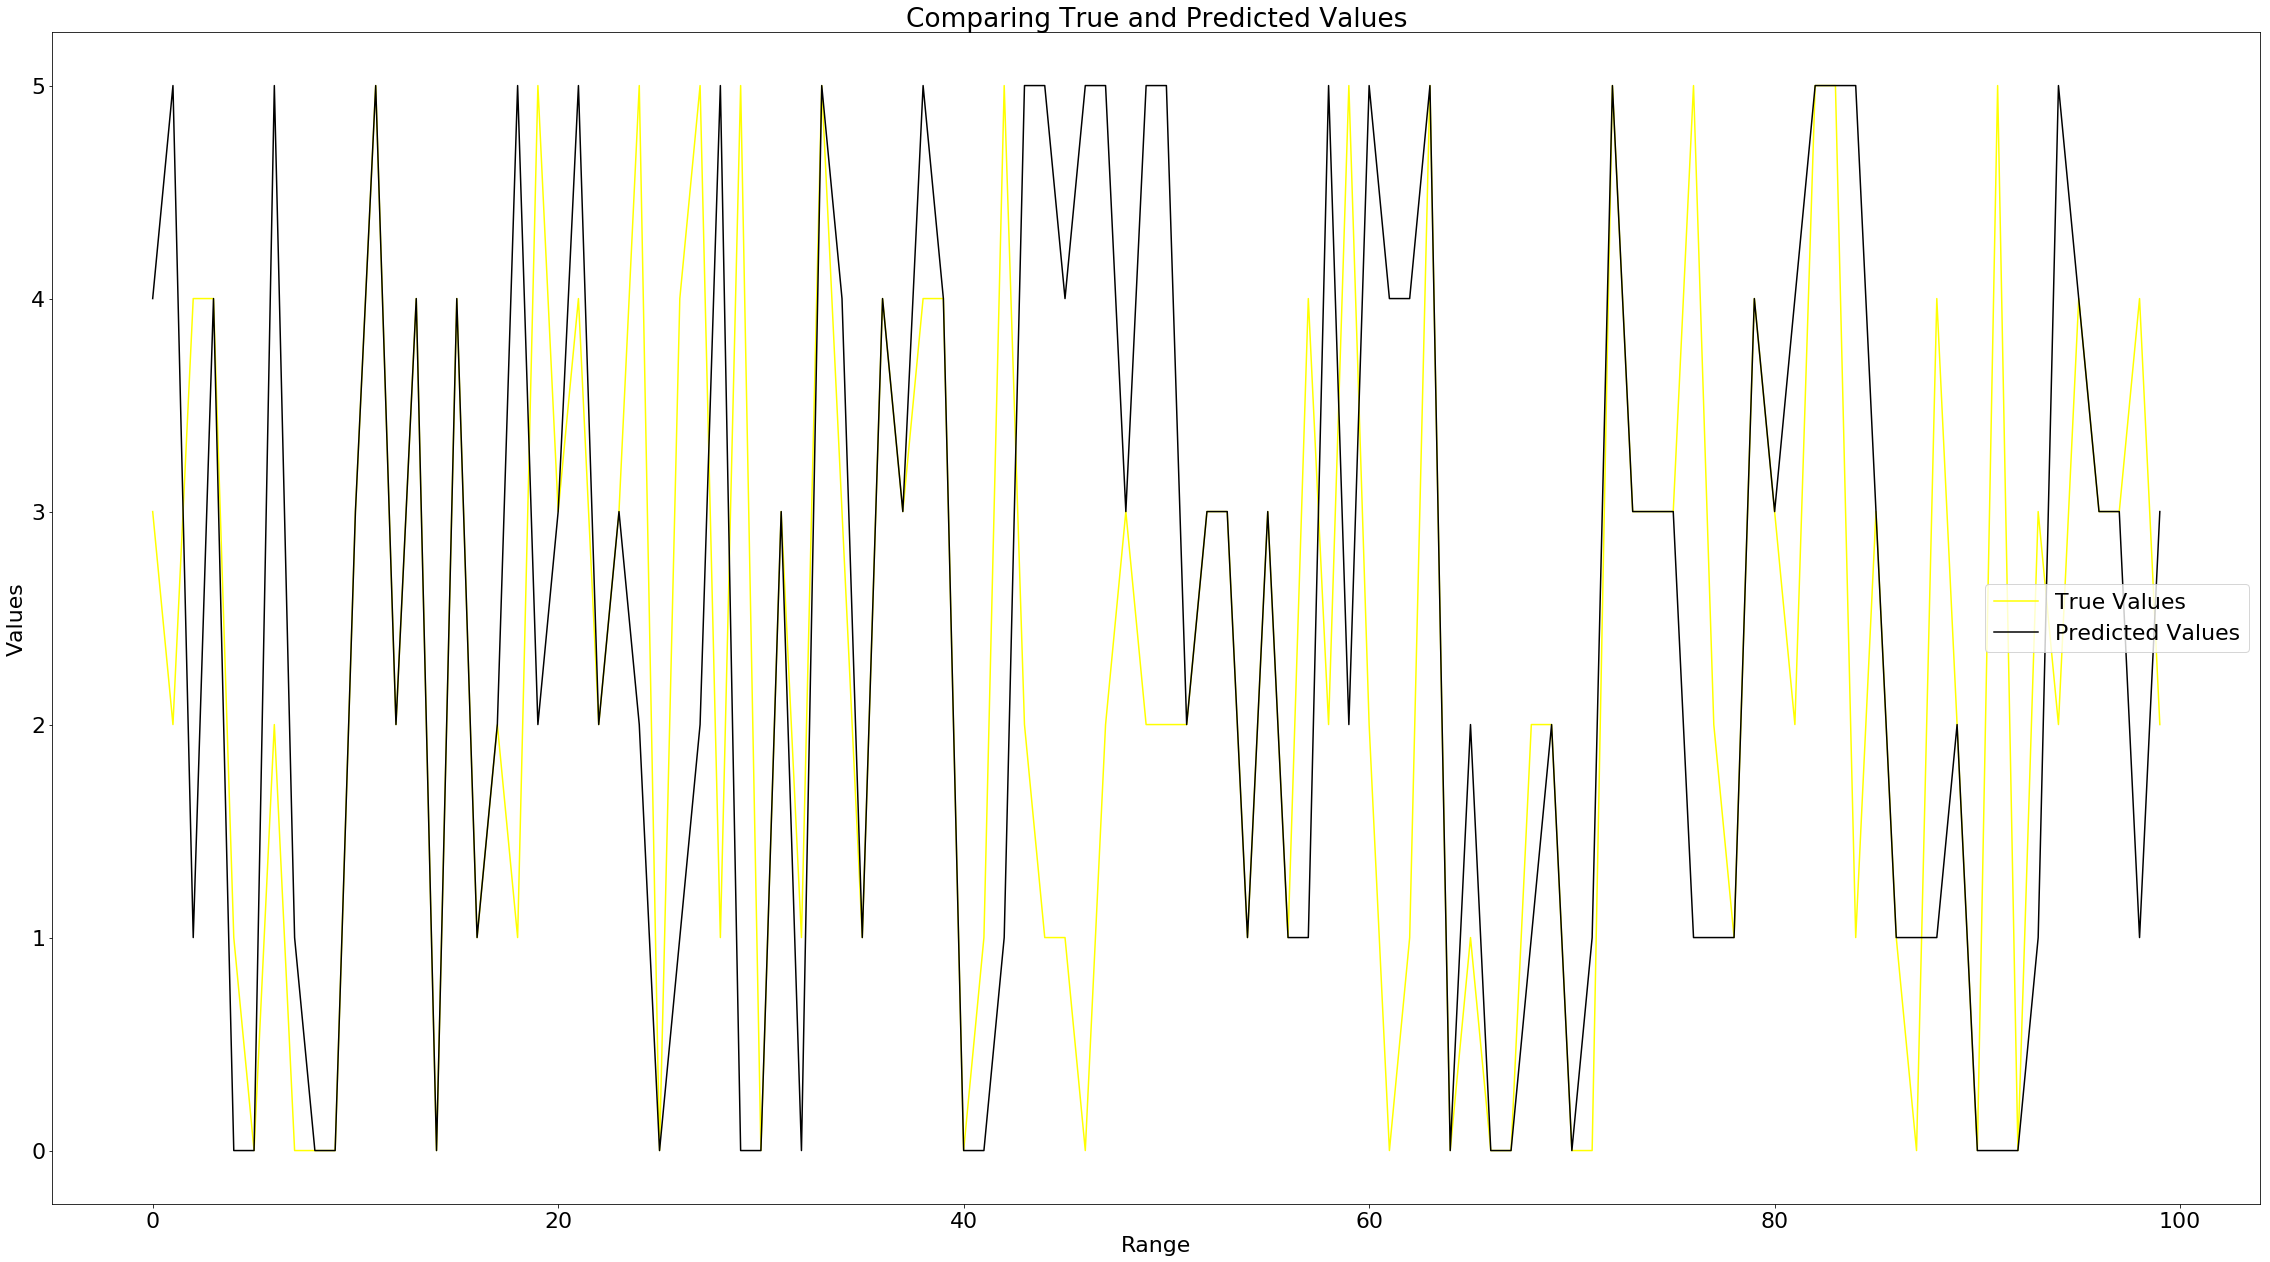

In [73]:
# Make the images larger

plt.rcParams['figure.figsize'] = (32, 18)
matplotlib.rcParams.update({'font.size': 22})
figsize = (10,10)
point_size=150
point_border=0.8
plt.xlabel('Range')
plt.ylabel('Values')
plt.plot(range(100), valid.Class.values[:100], color = 'yellow', label = 'True Values')
plt.plot(range(100), np.argmax(nn.predict(valid[features].values), axis=1)[:100], color = 'black', label = 'Predicted Values')
plt.title('Comparing True and Predicted Values')
plt.legend()

plt.tight_layout()

In [80]:
def makeConMat(cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(pd.DataFrame(cm , index = ['Electron', 'Ghost', 'Kaon', 'Muon', 'Pion', 'Proton'] , columns = ['Electron', 'Ghost', 'Kaon', 'Muon', 'Pion', 'Proton']),cmap= "coolwarm", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',cbar=False)
    plt.show()

**Plotting Confusion Matrix**

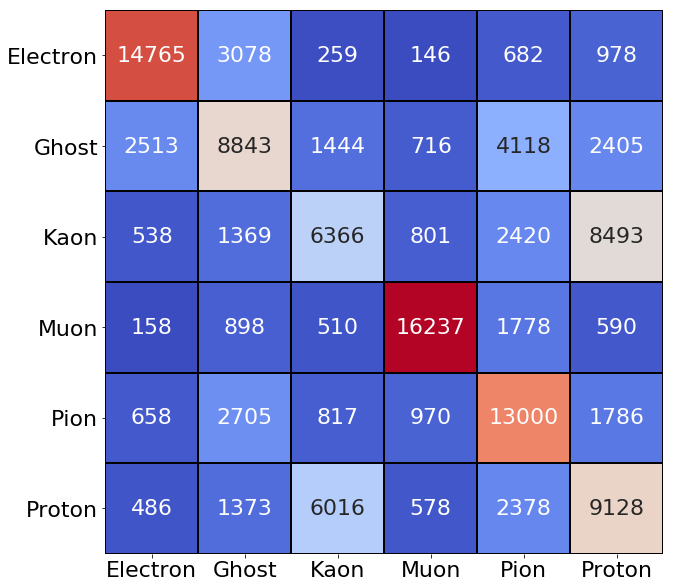

In [83]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valid.Class.values, np.argmax(nn.predict(valid[features].values), axis=1))
makeConMat(cm)

# **Random Forests for classification**

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(max_depth=40, random_state=0, n_estimators = 10 )
clf.fit(train[features].values, train.Class.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [87]:
print(clf.predict(valid[features].values))


[3 2 5 ... 4 3 0]


In [88]:
print(clf.predict_proba(valid[features].values))

[[0.2        0.         0.         0.5        0.3        0.        ]
 [0.         0.         0.6        0.         0.         0.4       ]
 [0.2        0.2        0.1        0.1        0.1        0.3       ]
 ...
 [0.         0.         0.3028514  0.00130719 0.59278173 0.10305969]
 [0.         0.         0.         0.9        0.1        0.        ]
 [0.5        0.         0.         0.2        0.3        0.        ]]


Of the first 100 rows of val lets see how many it predicted right

In [89]:
from sklearn.metrics import classification_report

target_names = ['Electron', 'Ghost', 'Kaon', 'Muon', 'Pion', 'Proton']
print(classification_report(valid.Class.values, clf.predict(valid[features].values), target_names=target_names))

              precision    recall  f1-score   support

    Electron       0.85      0.88      0.87     19908
       Ghost       0.73      0.76      0.74     20039
        Kaon       0.59      0.61      0.60     19987
        Muon       0.91      0.90      0.90     20171
        Pion       0.72      0.74      0.73     19936
      Proton       0.62      0.54      0.58     19959

   micro avg       0.74      0.74      0.74    120000
   macro avg       0.74      0.74      0.74    120000
weighted avg       0.74      0.74      0.74    120000



plotting the first 100 values so as to get an idea of our models performance

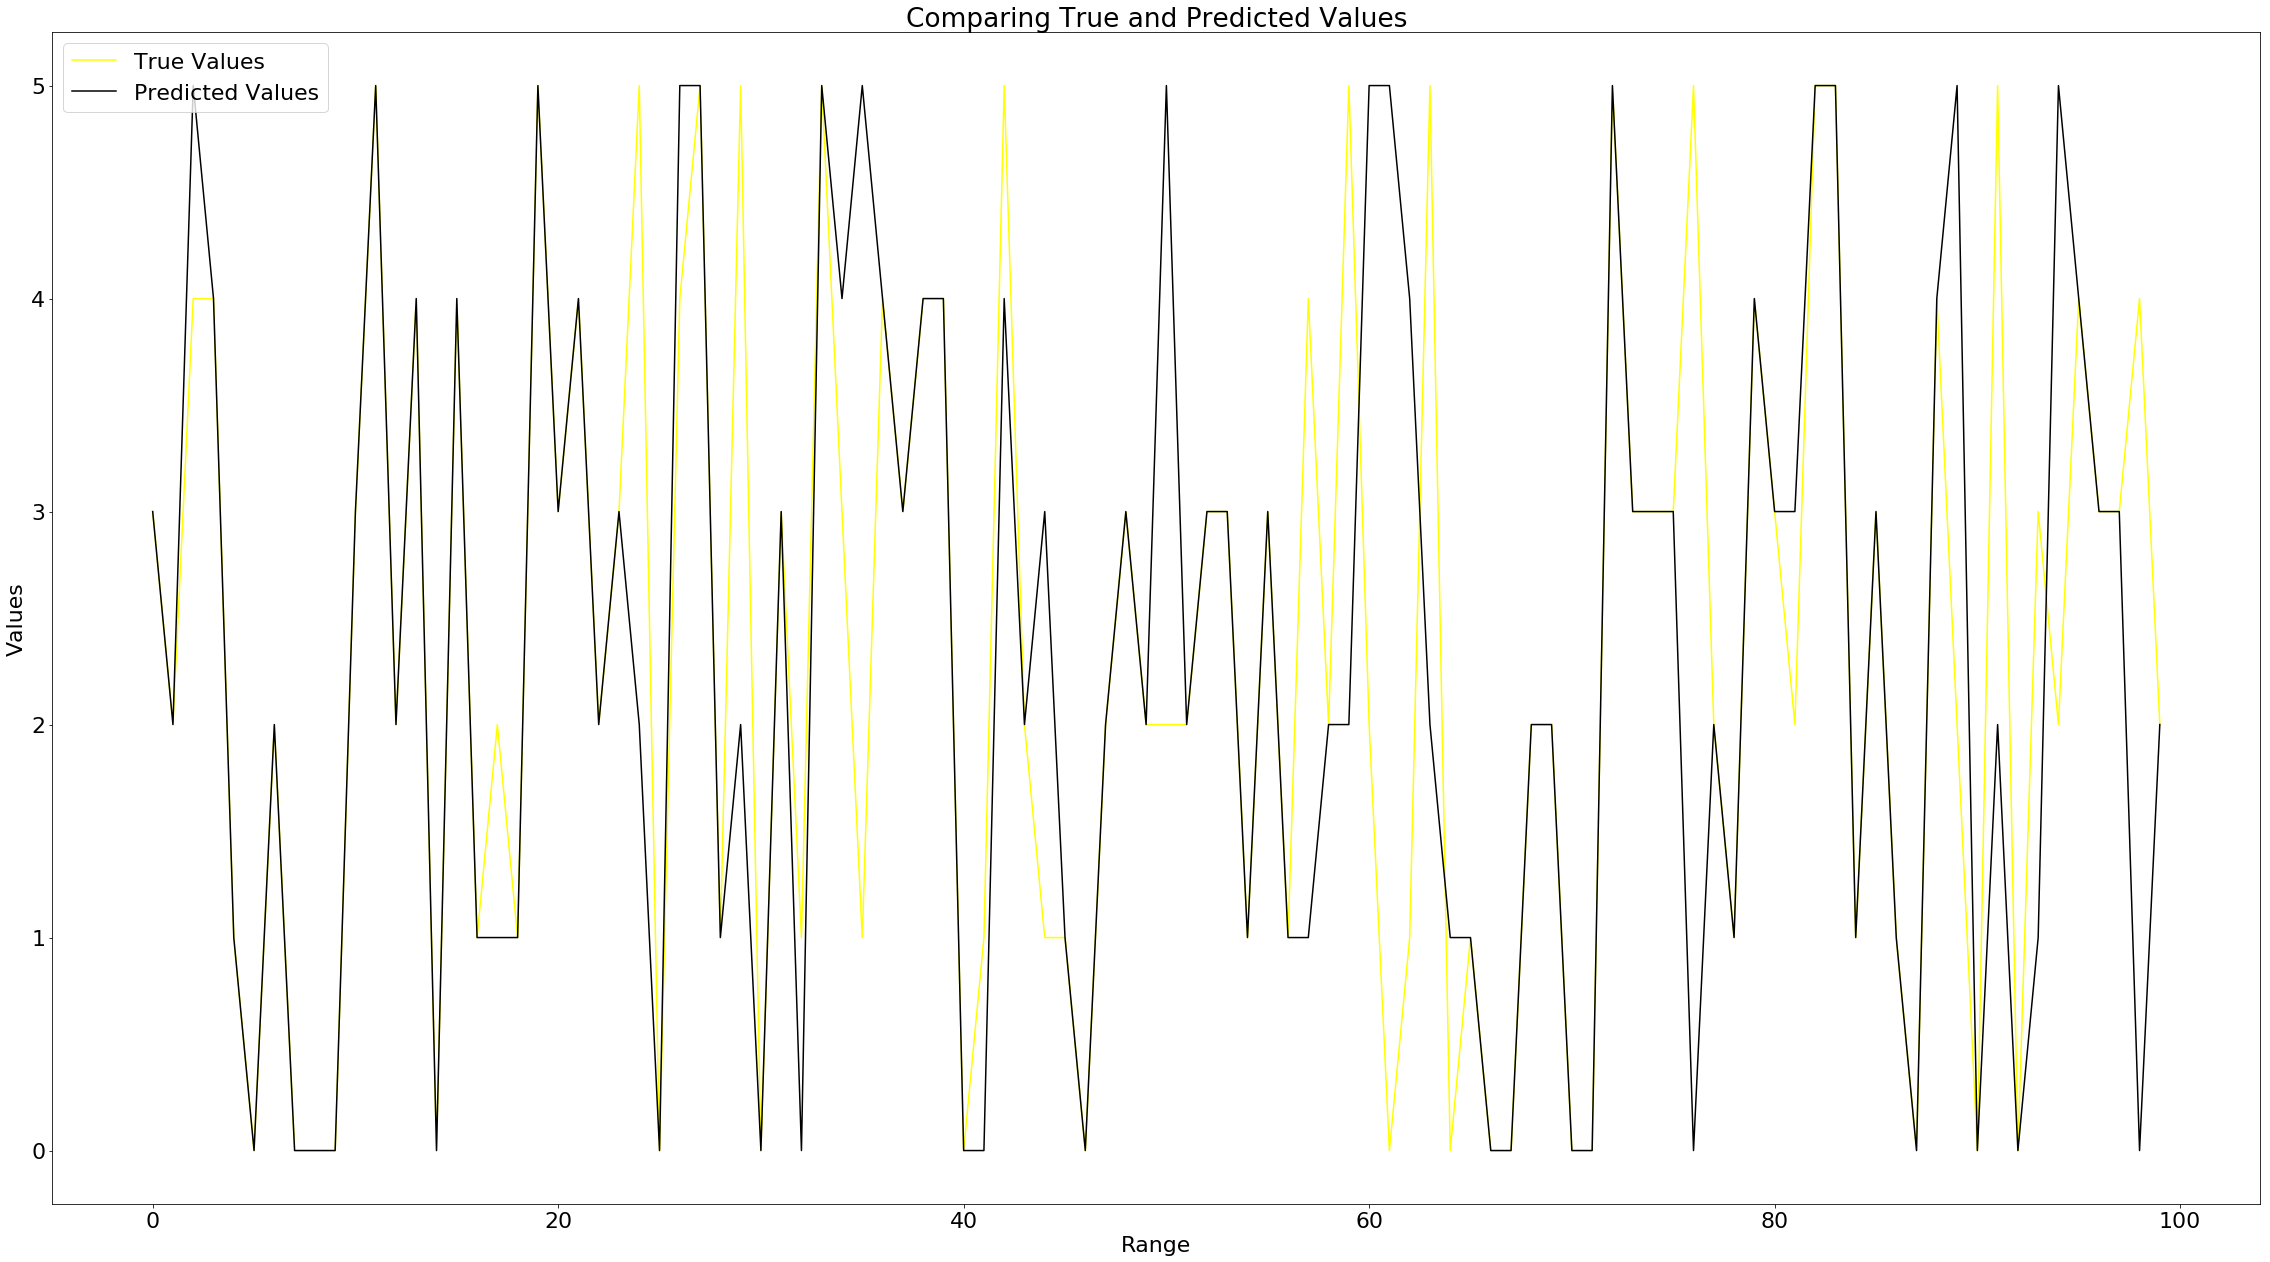

In [90]:
plt.xlabel('Range')
plt.ylabel('Values')
plt.plot(range(100), valid.Class.values[:100], color = 'yellow', label = 'True Values')
plt.plot(range(100), clf.predict(valid[features].values)[:100], color = 'black', label = 'Predicted Values')
plt.title('Comparing True and Predicted Values')
plt.legend()

plt.tight_layout()



**Confusion Matrix**

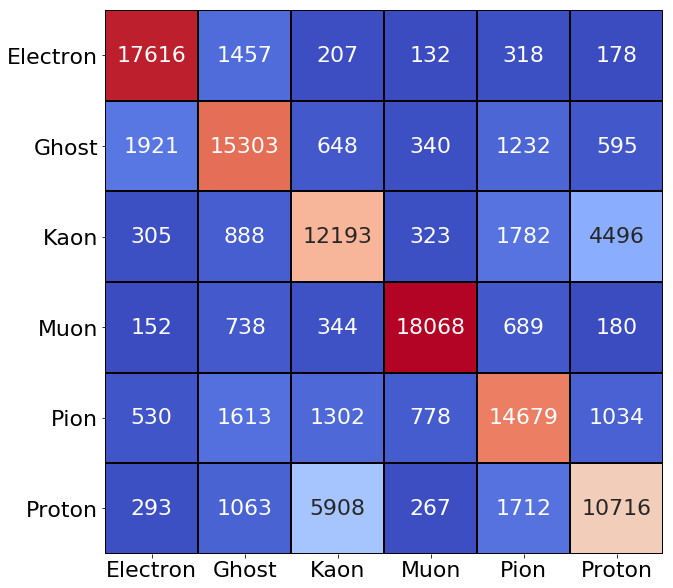

In [94]:
cm = confusion_matrix(valid.Class.values, clf.predict(valid[features].values))
makeConMat(cm)

# Conclusion: From the graph and Confusion Matrix, we can clearly say that our Random Forests model performed better than the Neural Network
                        